In [ ]:
import pickle

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount("./gdrive")

Mounted at ./gdrive


# Util Functions

In [ ]:
def from_raw_to_dataframe(x_raw, y_raw):
    tabular_list = []
    for i_sample, x in enumerate(x_raw):
        for i_time, xx in enumerate(x):
            tabular_list.append([i_sample, i_time] + list(xx) + [y_raw[i_sample]])
    df_res = pd.DataFrame(tabular_list).rename(columns={
        0: 'sample_id',
        1: 'time',
        2: 'feat_1',
        3: 'feat_2',
        4: 'feat_3',
        5: 'feat_4',
        6: 'feat_5',
        7: 'feat_6',
        8: 'label'}, inplace=False, errors='raise')
    return df_res

In [ ]:
def build_sequences(df):
    # Sanity check to avoid runtime errors
    #assert window % stride == 0
    dataset = []
    labels = []
    for id in df['sample_id'].unique():
        # Take only meaningful features
        temp = df[df['sample_id'] == id][['feat_1','feat_2','feat_3','feat_4','feat_5','feat_6']].values
        # Save the label
        label = df[df['sample_id'] == id]['label'].values[0]
        labels.append(label)
        dataset.append(temp)

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
def apply_scaler_to_new_data(x,y,scaler):
  x_original_tabular = from_raw_to_dataframe(x, y)
  x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']] = scaler.transform(x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])
  agg_x, agg_y = build_sequences(x_original_tabular)
  return agg_x, agg_y

# Data Load

In [ ]:
# load data split
with open("./gdrive/MyDrive/ann_dataset/HW2/dataUsed/train_test_objKeep9", "rb") as f:
  x_train, x_test, y_train, y_test = pickle.load(f)

In [ ]:
# load scaler
with open("./gdrive/MyDrive/ann_dataset/modelss/scaler.p", "rb") as f:
  scaler = pickle.load(f)

In [ ]:
x_train_norm, y_train_norm = apply_scaler_to_new_data(x_train, y_train, scaler)
x_test_norm, y_test_norm = apply_scaler_to_new_data(x_test, y_test, scaler)

In [ ]:
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train_norm)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test_norm)).batch(BATCH_SIZE)

In [ ]:
n_classes = 12

one of this function is probably faulty and creating information leakage from validation to train, main reason for which we preferred to use always the same split loaded from disck

In [ ]:
def oversample_data(x_train, y_train):
    lengths = []
    for label in np.unique(y_train):
        lengths.append(np.sum(y_train == label))
    id_max = np.argmax(lengths)
    max_len = lengths[id_max]

    x_train_aug = []
    y_train_aug = []
    for label in np.unique(y_train):
        samples = x_train[y_train == label]
        labels = y_train[y_train == label]
        indexes = list(np.random.randint(len(samples), size=max_len-len(samples)))
        extra_samples = samples[indexes]
        extra_labels = labels[indexes]
        x_train_aug += list(samples) + list(extra_samples)
        y_train_aug += list(labels) + list(extra_labels)

    return np.array(x_train_aug), np.array(y_train_aug)

In [ ]:
def oversample_data_above_t(x_train, y_train):
    x_train_aug = []
    y_train_aug = []
    for label in np.unique(y_train):
        samples = x_train[y_train == label]
        labels = y_train[y_train == label]
        if len(samples) <= 300:
          indexes = list(np.random.randint(len(samples), size=300-len(samples)))
          idxs = np.random.choice(indexes, size=(300-len(samples)))
          extra_samples = samples[idxs]
          extra_labels = labels[indexes]
          x_train_aug += list(samples) + list(extra_samples)
          y_train_aug += list(labels) + list(extra_labels)
        else:
            x_train_aug += list(samples)
            y_train_aug += list(labels)

    return np.array(x_train_aug), np.array(y_train_aug)

In [ ]:
def undersample_data(x_train, y_train, n_undersampled = 300):
    max_len = n_undersampled

    x_train_aug = []
    y_train_aug = []
    for label in np.unique(y_train):
        samples = x_train[y_train == label]
        labels = y_train[y_train == label]
        if len(samples) >= max_len:
            indexes = list(np.random.randint(len(samples)))
            indexes = list(np.random.choice(indexes, size=max_len, replace=False))
            u_samples = samples[indexes]
            u_labels = labels[indexes]
            x_train_aug += list(u_samples)
            y_train_aug += list(u_labels)
        else:
            x_train_aug += list(samples)
            y_train_aug += list(labels)

    return np.array(x_train_aug), np.array(y_train_aug)

In [ ]:
def print_representance(y):
    tot = len(y)
    strings = []
    lengths = []
    for label in np.unique(y):
        n = np.sum(y == label)
        strings.append(f"class-{label}  -> \t{n}\t\t{n / tot:.2}\t\t{(n / tot * 100):.4}%")
        lengths.append(n)\

    for i in np.argsort(lengths)[::-1]:
        print(strings[i])

# Transoformer build functions

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu", kernel_initializer = tf.keras.initializers.HeNormal())(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax", kernel_initializer = tf.keras.initializers.HeNormal())(x)
    return keras.Model(inputs, outputs)

# Commented faulty code of transformer scoring 0.8 bug

In [ ]:
# Load the data
"""x_original = np.load('./gdrive/MyDrive/ann_dataset/HW2/x_train.npy') # Shape: (2429, 36, 6)
y_original = np.load('./gdrive/MyDrive/ann_dataset/HW2/y_train.npy') # Labels"""

"""keep = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 9]  # classes to keep in the training

x_tmp = []
y_tmp = []
for i, y in enumerate(y_original):
    if y in keep:
        x_tmp.append(x_original[i])
        y_tmp.append(y)
x_original = np.array(x_tmp)
y_original = np.array(y_tmp)

print(x_original.shape)
print(y_original.shape)"""

'keep = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 9]  # classes to keep in the training\n\nx_tmp = []\ny_tmp = []\nfor i, y in enumerate(y_original):\n    if y in keep:\n        x_tmp.append(x_original[i])\n        y_tmp.append(y)\nx_original = np.array(x_tmp)\ny_original = np.array(y_tmp)\n\nprint(x_original.shape)\nprint(y_original.shape)'

In [ ]:
"""READ_FROM_LOCAL = False

if not READ_FROM_LOCAL:
    train_test_trans_obj = train_test_split(x_original, y_original, test_size=0.2, shuffle=True)
    x, x_test, y, y_test = train_test_trans_obj

   # with open("./dataUsed/train_test_trans_obj", "wb") as f:
    #    pickle.dump(train_test_trans_obj, f)
else:
    with open("./dataUsed/train_test_trans_obj", "3b") as f:
        x, x_test, y, y_test = pickle.load(f)"""

In [ ]:
"""print_representance(y_original)"""

class-9  -> 	777		0.32		31.99%
class-3  -> 	381		0.16		15.69%
class-6  -> 	313		0.13		12.89%
class-2  -> 	270		0.11		11.12%
class-5  -> 	153		0.063		6.299%
class-1  -> 	123		0.051		5.064%
class-8  -> 	120		0.049		4.94%
class-10  -> 	77		0.032		3.17%
class-7  -> 	68		0.028		2.8%
class-4  -> 	62		0.026		2.552%
class-11  -> 	51		0.021		2.1%
class-0  -> 	34		0.014		1.4%


In [ ]:
# x, y = undersample_data(x_original, y_original, n_undersampled=300) # first limit the classes undersampling
"""x, y = oversample_data_above_t(x, y)  # oversample low frequency classes

idxs = np.arange(len(y))
np.random.shuffle(idxs)
x = x[idxs]
y = y[idxs]
x.shape"""

(3920, 36, 6)

In [ ]:
"""print_representance(y)"""

class-9  -> 	617		0.16		15.72%
class-3  -> 	309		0.079		7.871%
class-11  -> 	300		0.076		7.641%
class-10  -> 	300		0.076		7.641%
class-8  -> 	300		0.076		7.641%
class-7  -> 	300		0.076		7.641%
class-6  -> 	300		0.076		7.641%
class-5  -> 	300		0.076		7.641%
class-4  -> 	300		0.076		7.641%
class-2  -> 	300		0.076		7.641%
class-1  -> 	300		0.076		7.641%
class-0  -> 	300		0.076		7.641%


In [ ]:
"""KEEP_ONE_FEATURE = True
if KEEP_ONE_FEATURE:
  id = 3
  x = x[:, :,[id]]
  x_test = x_test[:, :,[id]]"""

In [ ]:
"""test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
BATCH_SIZE = 128
test_dataset = test_dataset.batch(BATCH_SIZE)"""

# Compilation and training

In [ ]:
input_shape = x_train_norm.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=32,
    ff_dim=32,
    num_transformer_blocks=12,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

"""model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)
)"""

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(5e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',patience=100, restore_best_weights=True)]

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 layer_normalization_152 (Layer  (None, 36, 6)       12          ['input_9[0][0]']                
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_76 (Multi  (None, 36, 6)       221190      ['layer_normalization_152[0][0]',
 HeadAttention)                                                   'layer_normalization_152[0][0]']
                                                                                            

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=3000,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    # class_weight=class_weight
).history

# model.evaluate(x_test, y_test, verbose=1)

Epoch 1/3000
16/16 [==============================] - 14s 222ms/step - loss: 35.1978 - sparse_categorical_accuracy: 0.0623 - val_loss: 22.8019 - val_sparse_categorical_accuracy: 0.0679
Epoch 2/3000
16/16 [==============================] - 2s 146ms/step - loss: 29.9209 - sparse_categorical_accuracy: 0.0633 - val_loss: 18.8776 - val_sparse_categorical_accuracy: 0.0905
Epoch 3/3000
16/16 [==============================] - 2s 146ms/step - loss: 24.0561 - sparse_categorical_accuracy: 0.0870 - val_loss: 16.3482 - val_sparse_categorical_accuracy: 0.0947
Epoch 4/3000
16/16 [==============================] - 2s 146ms/step - loss: 23.4871 - sparse_categorical_accuracy: 0.0808 - val_loss: 14.5188 - val_sparse_categorical_accuracy: 0.1337
Epoch 5/3000
16/16 [==============================] - 2s 142ms/step - loss: 19.6646 - sparse_categorical_accuracy: 0.0973 - val_loss: 12.9360 - val_sparse_categorical_accuracy: 0.1296
Epoch 6/3000
16/16 [==============================] - 2s 146ms/step - loss: 18.

In [ ]:
import matplotlib.pyplot as plt


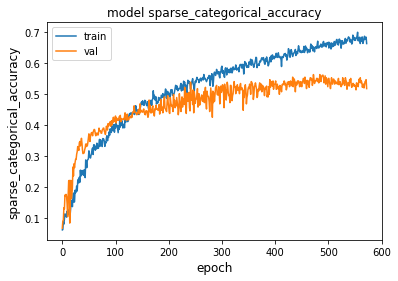

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history[metric])
plt.plot(history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

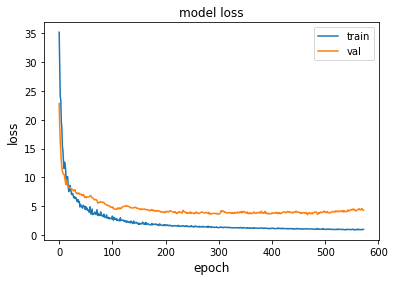

In [ ]:
metric = "loss"
plt.figure()
plt.plot(history[metric])
plt.plot(history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

# Evaluate model

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [ ]:
def show_confusion(model, validation_dataset):
    Y_pred = model.predict(validation_dataset)
    y_pred = np.argmax(Y_pred, axis=1)
    y_test= np.concatenate([y for x, y in validation_dataset], axis=0)

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    f1_scores = f1_score(y_test, y_pred, average=None)
    mean_f1 = np.mean(f1_scores)

    print(f"\nF1 scores: {f1_scores}")
    print(f"\nMean F1 : {mean_f1}")
    print(f"\nAccuracy : {accuracy_score(y_test, y_pred)}")

4/4 [==============================] - 1s 53ms/step


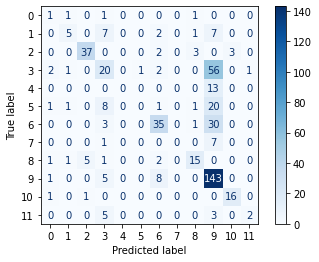


F1 scores: [0.18181818 0.32258065 0.84090909 0.29850746 0.         0.
 0.5785124  0.         0.63829787 0.6559633  0.86486486 0.30769231]

Mean F1 : 0.390762177076603

Accuracy : 0.5637860082304527


In [ ]:
show_confusion(model, test_dataset)

In [ ]:
# save history
with open("./dataUsed/historyTrans04", "wb") as f:
    pickle.dump(history, f)

In [ ]:
# save model locally and zipped on drive
name = "./modeltrans_allfeat_080"
model.save(name)
!zip -r ./gdrive/MyDrive/ann_dataset/HW2/{name}.zip ./{name}

  adding: modeltrans_allfeat_080/ (stored 0%)
  adding: modeltrans_allfeat_080/assets/ (stored 0%)
  adding: modeltrans_allfeat_080/variables/ (stored 0%)
  adding: modeltrans_allfeat_080/variables/variables.index (deflated 79%)
  adding: modeltrans_allfeat_080/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: modeltrans_allfeat_080/saved_model.pb (deflated 92%)
  adding: modeltrans_allfeat_080/keras_metadata.pb (deflated 95%)
